In [1]:
%config Completer.use_jedi = False

In [76]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.inspection import partial_dependence
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt
from matplotlib import rcParams

In [55]:
loan_table = pd.read_csv('loan_table.csv')
loan_table.head()

,loan_id,loan_purpose,date,loan_granted,loan_repaid
0,19454,investment,2012-03-15,0,NaN
1,496811,investment,2012-01-17,0,NaN
2,929493,other,2012-02-09,0,NaN
3,580653,other,2012-06-27,1,1.0
4,172419,business,2012-05-21,1,0.0


In [56]:
borrower_table = pd.read_csv('borrower_table.csv')
borrower_table.head()


,loan_id,is_first_loan,fully_repaid_previous_loans,currently_repaying_other_loans,total_credit_card_limit,avg_percentage_credit_card_limit_used_last_year,saving_amount,checking_amount,is_employed,yearly_salary,age,dependent_number
0,289774,1,NaN,NaN,8000,0.49,3285,1073,0,0,47,3
1,482590,0,1.0,0.0,4500,1.03,636,5299,1,13500,33,1
2,135565,1,NaN,NaN,6900,0.82,2085,3422,1,24500,38,8
3,207797,0,1.0,0.0,1200,0.82,358,3388,0,0,24,1
4,828078,0,0.0,0.0,6900,0.80,2138,4282,1,18100,36,1


In [57]:
# check data quality
loan_table['date']=pd.to_datetime(loan_table['date'])
loan_table.describe()

,loan_id,date,loan_granted,loan_repaid
count,101100.000000,101100,101100.000000,47654.000000
mean,499666.826726,2012-06-30 02:13:28.451038464,0.471355,0.644353
min,30.000000,2012-01-02 00:00:00,0.000000,0.000000
25%,250333.750000,2012-04-02 00:00:00,0.000000,0.000000
50%,499885.000000,2012-06-29 00:00:00,0.000000,1.000000
75%,749706.250000,2012-09-28 00:00:00,1.000000,1.000000
max,999987.000000,2012-12-28 00:00:00,1.000000,1.000000
std,288662.006929,NaN,0.499181,0.478714


In [58]:
loan_table.loan_id.nunique()

101100

In [59]:
loan_table.query('loan_granted==0 and loan_repaid==1')

,loan_id,loan_purpose,date,loan_granted,loan_repaid


In [60]:
borrower_table.describe()

,loan_id,is_first_loan,fully_repaid_previous_loans,currently_repaying_other_loans,total_credit_card_limit,avg_percentage_credit_card_limit_used_last_year,saving_amount,checking_amount,is_employed,yearly_salary,age,dependent_number
count,101100.000000,101100.000000,46153.000000,46153.000000,101100.000000,94128.000000,101100.000000,101100.000000,101100.000000,101100.000000,101100.000000,101100.000000
mean,499666.826726,0.543492,0.899291,0.364332,4112.743818,0.724140,1799.617616,3177.150821,0.658675,21020.727992,41.491632,3.864748
std,288662.006929,0.498107,0.300946,0.481247,2129.121462,0.186483,1400.545141,2044.448155,0.474157,18937.581415,12.825570,2.635491
min,30.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000,0.000000
25%,250333.750000,0.000000,1.000000,0.000000,2700.000000,0.600000,834.000000,1706.000000,0.000000,0.000000,32.000000,2.000000
50%,499885.000000,1.000000,1.000000,0.000000,4100.000000,0.730000,1339.000000,2673.000000,1.000000,21500.000000,41.000000,3.000000
75%,749706.250000,1.000000,1.000000,1.000000,5500.000000,0.860000,2409.000000,4241.000000,1.000000,35300.000000,50.000000,6.000000
max,999987.000000,1.000000,1.000000,1.000000,13500.000000,1.090000,10641.000000,13906.000000,1.000000,97200.000000,79.000000,8.000000


In [61]:

borrower_table.query('avg_percentage_credit_card_limit_used_last_year.isnull()')['total_credit_card_limit'].sum()

np.int64(0)

In [62]:
borrower_table.loan_id.nunique()

101100

In [63]:
# bank profitability
loan_table.query('loan_granted==1 and loan_repaid==1').shape[0]-loan_table.query('loan_granted==1 and loan_repaid==0').shape[0]

13758

In [64]:
# merge data 
df_merge = loan_table.merge(borrower_table, how='inner', on = 'loan_id')
df_merge.head()

,loan_id,loan_purpose,date,loan_granted,loan_repaid,is_first_loan,fully_repaid_previous_loans,currently_repaying_other_loans,total_credit_card_limit,avg_percentage_credit_card_limit_used_last_year,saving_amount,checking_amount,is_employed,yearly_salary,age,dependent_number
0,19454,investment,2012-03-15,0,NaN,1,NaN,NaN,8600,0.79,1491,6285,1,45200,42,7
1,496811,investment,2012-01-17,0,NaN,1,NaN,NaN,5300,0.52,141,5793,0,0,42,5
2,929493,other,2012-02-09,0,NaN,1,NaN,NaN,0,NaN,660,3232,1,26500,60,4
3,580653,other,2012-06-27,1,1.0,0,1.0,0.0,5400,0.52,3345,2764,1,15800,58,4
4,172419,business,2012-05-21,1,0.0,1,NaN,NaN,2900,0.76,1050,3695,1,34800,31,4


In [12]:
numeric_df = df_merge.select_dtypes(include='number').drop(columns = ['loan_id'])

In [65]:
# deal with missing values

In [ ]:
# The dataset has a lot of NAs. 
# As a first step, we will need to deal with them.
# The general rule on how to deal with NAs is to firstly find out if they are random or they actually happen based on some rule.
# If they are random, we can either remove those rows or impute them (mean, median, etc.). 
# On the other hand, if they do happen for a reason, we need to replace them with a specific value such that we don’t lose that information.

In [68]:
df_merge.isnull().sum().sort_values(ascending=False)

fully_repaid_previous_loans                        54947
currently_repaying_other_loans                     54947
loan_repaid                                        53446
avg_percentage_credit_card_limit_used_last_year     6972
loan_id                                                0
loan_purpose                                           0
date                                                   0
loan_granted                                           0
is_first_loan                                          0
total_credit_card_limit                                0
saving_amount                                          0
checking_amount                                        0
is_employed                                            0
yearly_salary                                          0
age                                                    0
dependent_number                                       0
dtype: int64

In [73]:
df_merge.query('fully_repaid_previous_loans.isnull()')\
[['currently_repaying_other_loans','loan_repaid','avg_percentage_credit_card_limit_used_last_year']].sum()

currently_repaying_other_loans                         0.00
loan_repaid                                        16763.00
avg_percentage_credit_card_limit_used_last_year    37011.92
dtype: float64

In [ ]:
# it means if fully_repaid_previous_loans is null, currently_repaying_other_loans is also null -> they're requesting loan first time

In [75]:
df_merge.query('avg_percentage_credit_card_limit_used_last_year.isnull()')\
[['currently_repaying_other_loans','fully_repaid_previous_loans','loan_repaid']].sum()

currently_repaying_other_loans    1645.0
fully_repaid_previous_loans       2789.0
loan_repaid                        156.0
dtype: float64

In [13]:
numeric_df.head()

,loan_granted,loan_repaid,is_first_loan,fully_repaid_previous_loans,currently_repaying_other_loans,total_credit_card_limit,avg_percentage_credit_card_limit_used_last_year,saving_amount,checking_amount,is_employed,yearly_salary,age,dependent_number
0,0,NaN,1,NaN,NaN,8600,0.79,1491,6285,1,45200,42,7
1,0,NaN,1,NaN,NaN,5300,0.52,141,5793,0,0,42,5
2,0,NaN,1,NaN,NaN,0,NaN,660,3232,1,26500,60,4
3,1,1.0,0,1.0,0.0,5400,0.52,3345,2764,1,15800,58,4
4,1,0.0,1,NaN,NaN,2900,0.76,1050,3695,1,34800,31,4


In [14]:
numeric_df.columns 

Index(['loan_granted', 'loan_repaid', 'is_first_loan',
       'fully_repaid_previous_loans', 'currently_repaying_other_loans',
       'total_credit_card_limit',
       'avg_percentage_credit_card_limit_used_last_year', 'saving_amount',
       'checking_amount', 'is_employed', 'yearly_salary', 'age',
       'dependent_number'],
      dtype='object')

In [15]:
# By default, df.corr() ignores missing values when computing correlations.

# It uses pairwise deletion — this means:

# For each pair of columns, it drops any row where either column has a missing value.

# Then it calculates the correlation only on the remaining (non-missing) rows for that pair.

In [16]:
non_missing_df = numeric_df[['loan_granted','is_first_loan','total_credit_card_limit','saving_amount',\
       'checking_amount', 'is_employed', 'yearly_salary', 'age',\
       'dependent_number']]

In [17]:
non_missing_df.corr() # salary and is_employed are highly correlated 

,loan_granted,is_first_loan,total_credit_card_limit,saving_amount,checking_amount,is_employed,yearly_salary,age,dependent_number
loan_granted,1.000000,-0.004398,0.184099,0.150180,0.148726,0.500165,0.410128,0.002431,-0.040237
is_first_loan,-0.004398,1.000000,0.000679,0.005650,0.005114,-0.000971,-0.001674,-0.002353,0.000887
total_credit_card_limit,0.184099,0.000679,1.000000,0.234181,0.240926,0.195274,0.222497,-0.004052,-0.058650
saving_amount,0.150180,0.005650,0.234181,1.000000,0.301041,0.248526,0.288712,-0.005321,-0.075647
checking_amount,0.148726,0.005114,0.240926,0.301041,1.000000,0.244383,0.282909,0.000355,-0.081963
is_employed,0.500165,-0.000971,0.195274,0.248526,0.244383,1.000000,0.799051,0.005059,-0.060847
yearly_salary,0.410128,-0.001674,0.222497,0.288712,0.282909,0.799051,1.000000,0.005412,-0.073218
age,0.002431,-0.002353,-0.004052,-0.005321,0.000355,0.005059,0.005412,1.000000,0.000862
dependent_number,-0.040237,0.000887,-0.058650,-0.075647,-0.081963,-0.060847,-0.073218,0.000862,1.000000


In [18]:
non_missing_df.corr().where(lambda x: x>0.5).stack().reset_index().query("level_0 != level_1").\
assign(pair=lambda df: df[['level_0', 'level_1']].apply(lambda row: tuple(sorted(row)), axis=1))\
.drop_duplicates('pair')

# sorted(row): sorts the pair alphabetically (so both (A, B) and (B, A) become (A, B)).

# tuple(...): converts the sorted list to a tuple, which is hashable and usable for .drop_duplicates().

# .assign(pair=...): adds this new column pair to the DataFrame.



,level_0,level_1,0,pair
1,loan_granted,is_employed,0.500165,"(is_employed, loan_granted)"
8,is_employed,yearly_salary,0.799051,"(is_employed, yearly_salary)"


In [19]:
df_merge.head()

,loan_id,loan_purpose,date,loan_granted,loan_repaid,is_first_loan,fully_repaid_previous_loans,currently_repaying_other_loans,total_credit_card_limit,avg_percentage_credit_card_limit_used_last_year,saving_amount,checking_amount,is_employed,yearly_salary,age,dependent_number
0,19454,investment,2012-03-15,0,NaN,1,NaN,NaN,8600,0.79,1491,6285,1,45200,42,7
1,496811,investment,2012-01-17,0,NaN,1,NaN,NaN,5300,0.52,141,5793,0,0,42,5
2,929493,other,2012-02-09,0,NaN,1,NaN,NaN,0,NaN,660,3232,1,26500,60,4
3,580653,other,2012-06-27,1,1.0,0,1.0,0.0,5400,0.52,3345,2764,1,15800,58,4
4,172419,business,2012-05-21,1,0.0,1,NaN,NaN,2900,0.76,1050,3695,1,34800,31,4


In [20]:
agg_purpose = df_merge.groupby('loan_purpose').agg({'loan_id':'count','loan_granted':'sum'}).reset_index()
agg_purpose.head()

,loan_purpose,loan_id,loan_granted
0,business,21707,10773
1,emergency_funds,18091,7753
2,home,24314,11614
3,investment,21484,10603
4,other,15504,6911


In [21]:
agg_purpose['loan_pct'] = agg_purpose['loan_id']/agg_purpose['loan_id'].sum()
agg_purpose['granted_pct'] = agg_purpose['loan_granted']/agg_purpose['loan_granted'].sum()
agg_purpose.head()

,loan_purpose,loan_id,loan_granted,loan_pct,granted_pct
0,business,21707,10773,0.214708,0.226067
1,emergency_funds,18091,7753,0.178942,0.162694
2,home,24314,11614,0.240495,0.243715
3,investment,21484,10603,0.212502,0.222500
4,other,15504,6911,0.153353,0.145025


In [22]:
df_merge['quarter'] = df_merge['date'].dt.quarter

In [23]:
conditions= {'Q1':df_merge['quarter']==1,\
            'Q2':df_merge['quarter']==2,\
            'Q3':df_merge['quarter']==3,\
            'Q4':df_merge['quarter']==4}

In [24]:
df_merge['quarter_cat'] = np.select(conditions.values(),conditions.keys(), default = 'Partial')

In [25]:
df_merge.head()

,loan_id,loan_purpose,date,loan_granted,loan_repaid,is_first_loan,fully_repaid_previous_loans,currently_repaying_other_loans,total_credit_card_limit,avg_percentage_credit_card_limit_used_last_year,saving_amount,checking_amount,is_employed,yearly_salary,age,dependent_number,quarter,quarter_cat
0,19454,investment,2012-03-15,0,NaN,1,NaN,NaN,8600,0.79,1491,6285,1,45200,42,7,1,Q1
1,496811,investment,2012-01-17,0,NaN,1,NaN,NaN,5300,0.52,141,5793,0,0,42,5,1,Q1
2,929493,other,2012-02-09,0,NaN,1,NaN,NaN,0,NaN,660,3232,1,26500,60,4,1,Q1
3,580653,other,2012-06-27,1,1.0,0,1.0,0.0,5400,0.52,3345,2764,1,15800,58,4,2,Q2
4,172419,business,2012-05-21,1,0.0,1,NaN,NaN,2900,0.76,1050,3695,1,34800,31,4,2,Q2


In [26]:
df_dummy = pd.get_dummies(df_merge, drop_first=True, dtype = float)
df_dummy.columns
# reference level: biz, quarter

Index(['loan_id', 'date', 'loan_granted', 'loan_repaid', 'is_first_loan',
       'fully_repaid_previous_loans', 'currently_repaying_other_loans',
       'total_credit_card_limit',
       'avg_percentage_credit_card_limit_used_last_year', 'saving_amount',
       'checking_amount', 'is_employed', 'yearly_salary', 'age',
       'dependent_number', 'quarter', 'loan_purpose_emergency_funds',
       'loan_purpose_home', 'loan_purpose_investment', 'loan_purpose_other',
       'quarter_cat_Q2', 'quarter_cat_Q3', 'quarter_cat_Q4'],
      dtype='object')

In [27]:
df_dummy.groupby('loan_granted')['loan_id'].count().reset_index() # balanced dataset, no need to oversample/downsample

,loan_granted,loan_id
0,0,53446
1,1,47654


In [28]:
X = df_dummy.drop(columns = ['date', 'loan_granted','quarter'])
y = df_dummy['loan_granted']

In [29]:
# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_real = X_train.drop(columns = ['loan_id', 'loan_repaid'])
X_test_real = X_test.drop(columns = ['loan_id', 'loan_repaid'])
# Train XGBoost classifier
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train_real, y_train)

# Predict
y_pred = model.predict(X_test_real)



/Users/wentinggao/myenv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:34:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [30]:
# Confusion Matrix:
# [[TN FP]
#  [FN TP]]
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm,
                     index=['Not Granted', 'Granted'],
                     columns=['Predicted Not Granted', 'Predicted Granted'])

cm_df

,Predicted Not Granted,Predicted Granted
Not Granted,7220,3364
Granted,1191,8445


In [31]:
cm_df.iloc[0,1]

np.int64(3364)

In [32]:
Precision =  cm_df.iloc[1,1]/(cm_df.iloc[1,1]+cm_df.iloc[0,1])  #TP / (TP + FP)

Recall = cm_df.iloc[1,1]/(cm_df.iloc[1,1]+cm_df.iloc[1,0]) #TP / (TP + FN)
print("Precision:",Precision)
print("Recall:",Recall)

Precision: 0.7151325260394614
Recall: 0.8764009962640099


In [33]:
y_pred

array([0, 1, 0, ..., 1, 1, 1], shape=(20220,))

In [34]:
X_test['predicted_granted']=y_pred

In [35]:
X_test

,loan_id,loan_repaid,is_first_loan,fully_repaid_previous_loans,currently_repaying_other_loans,total_credit_card_limit,avg_percentage_credit_card_limit_used_last_year,saving_amount,checking_amount,is_employed,...,age,dependent_number,loan_purpose_emergency_funds,loan_purpose_home,loan_purpose_investment,loan_purpose_other,quarter_cat_Q2,quarter_cat_Q3,quarter_cat_Q4,predicted_granted
90091,97587,NaN,0,1.0,0.0,2800,0.49,2764,1368,0,...,25,8,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
32072,457819,1.0,0,1.0,0.0,6300,0.60,2383,3201,1,...,65,8,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1
47827,576861,NaN,0,1.0,1.0,0,NaN,943,3936,1,...,32,3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
30849,802922,NaN,0,1.0,1.0,2300,0.64,946,517,0,...,55,4,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0
44141,188691,NaN,0,1.0,0.0,1500,0.83,1331,3001,1,...,54,2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43651,977605,1.0,1,NaN,NaN,4700,0.42,1719,7507,1,...,69,2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1
49552,70546,1.0,1,NaN,NaN,5200,0.28,4231,6796,1,...,60,2,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1
13933,472767,1.0,0,0.0,0.0,4800,0.53,1793,3851,1,...,48,2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1
23152,715629,NaN,1,NaN,NaN,5000,0.84,1947,5172,1,...,53,2,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1


In [36]:
y_pred_train = model.predict(X_train_real)
X_train['predicted_granted']=y_pred_train

In [37]:
X_train

,loan_id,loan_repaid,is_first_loan,fully_repaid_previous_loans,currently_repaying_other_loans,total_credit_card_limit,avg_percentage_credit_card_limit_used_last_year,saving_amount,checking_amount,is_employed,...,age,dependent_number,loan_purpose_emergency_funds,loan_purpose_home,loan_purpose_investment,loan_purpose_other,quarter_cat_Q2,quarter_cat_Q3,quarter_cat_Q4,predicted_granted
4065,966511,1.0,0,1.0,0.0,5700,0.56,2473,6934,1,...,31,1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1
44441,749477,0.0,0,1.0,0.0,1500,0.69,138,3094,1,...,35,4,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1
34236,81915,0.0,1,NaN,NaN,3300,0.86,1340,1932,1,...,52,2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
63961,323947,NaN,1,NaN,NaN,3400,1.07,699,5389,1,...,30,4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
16936,404386,NaN,0,0.0,0.0,4200,0.83,1200,3329,1,...,30,7,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6265,245194,NaN,0,1.0,1.0,3100,0.44,1406,176,0,...,69,8,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0
54886,623208,NaN,1,NaN,NaN,0,NaN,1033,1884,0,...,72,6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
76820,190924,NaN,0,1.0,1.0,2400,0.78,603,2970,0,...,50,8,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0
860,691775,0.0,1,NaN,NaN,3100,0.77,1178,2494,1,...,62,8,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1


In [38]:
# bank profitability
loan_table.query('loan_granted==1 and loan_repaid==1').shape[0]-loan_table.query('loan_granted==1 and loan_repaid==0').shape[0]

13758

In [39]:
# model profitability
X_train.query('predicted_granted==1 and loan_repaid==1').shape[0]-X_train.query('predicted_granted==1 and loan_repaid==0').shape[0]+\
X_test.query('predicted_granted==1 and loan_repaid==1').shape[0]-X_test.query('predicted_granted==1 and loan_repaid==0').shape[0]

16661

In [40]:
16661/13758-1 #improve by 20%+

0.2110045064689634

In [41]:
# feature importance 
# Get feature importances
importance = model.feature_importances_

# Create a labeled DataFrame
importance_df = pd.DataFrame({
    'Feature': X_train_real.columns,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

print(importance_df)

                                            Feature  Importance
7                                       is_employed    0.956225
4   avg_percentage_credit_card_limit_used_last_year    0.012106
13                          loan_purpose_investment    0.002193
8                                     yearly_salary    0.002172
14                               loan_purpose_other    0.002117
15                                   quarter_cat_Q2    0.002070
6                                   checking_amount    0.002034
5                                     saving_amount    0.002001
1                       fully_repaid_previous_loans    0.001988
12                                loan_purpose_home    0.001945
11                     loan_purpose_emergency_funds    0.001945
9                                               age    0.001941
10                                 dependent_number    0.001909
16                                   quarter_cat_Q3    0.001899
3                           total_credit

In [43]:
print(X['is_employed'].unique())

[1 0]


In [44]:
# Plot partial dependence for 'is_employed'
X_pdp = X.drop(columns=['loan_id', 'loan_repaid'])

# partial_dependence(model, features=['is_employed'], X=X.drop(columns=['loan_id', 'loan_repaid']), percentiles=(0, 1), grid_resolution=2)

In [45]:
X_pdp.columns

Index(['is_first_loan', 'fully_repaid_previous_loans',
       'currently_repaying_other_loans', 'total_credit_card_limit',
       'avg_percentage_credit_card_limit_used_last_year', 'saving_amount',
       'checking_amount', 'is_employed', 'yearly_salary', 'age',
       'dependent_number', 'loan_purpose_emergency_funds', 'loan_purpose_home',
       'loan_purpose_investment', 'loan_purpose_other', 'quarter_cat_Q2',
       'quarter_cat_Q3', 'quarter_cat_Q4'],
      dtype='object')

In [49]:
# PartialDependenceDisplay.from_estimator(model,X_pdp,features=[(7,)],grid_resolution=2)

In [51]:
# Create SHAP explainer and values
import shap
explainer = shap.Explainer(model, X_train_real)
shap_values = explainer(X_train_real)

/Users/wentinggao/myenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
 99%|===================| 80375/80880 [02:02<00:00]        

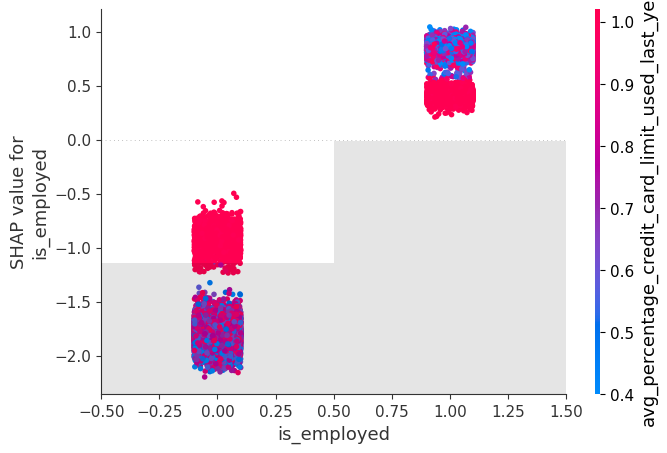

In [52]:
shap.plots.scatter(shap_values[:, 'is_employed'], color=shap_values)
# Being employed strongly increases predicted outcome.

# Not being employed generally reduces it.

# The impact may also depend on other features (like credit usage).

In [ ]:
## other features: indivual data - clustered data, previous loan info 

In [68]:
print(X['is_employed'].dtype)
print(X['is_employed'].unique())
print(X['is_employed'].value_counts())

int64
[1 0]
is_employed
1    66592
0    34508
Name: count, dtype: int64


In [85]:
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence

In [89]:
X_pdp

,is_first_loan,fully_repaid_previous_loans,currently_repaying_other_loans,total_credit_card_limit,avg_percentage_credit_card_limit_used_last_year,saving_amount,checking_amount,is_employed,yearly_salary,age,dependent_number,loan_purpose_emergency_funds,loan_purpose_home,loan_purpose_investment,loan_purpose_other,quarter_cat_Q2,quarter_cat_Q3,quarter_cat_Q4
0,1,NaN,NaN,8600,0.79,1491,6285,1.0,45200,42,7,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1,NaN,NaN,5300,0.52,141,5793,0.0,0,42,5,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1,NaN,NaN,0,NaN,660,3232,1.0,26500,60,4,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0,1.0,0.0,5400,0.52,3345,2764,1.0,15800,58,4,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,1,NaN,NaN,2900,0.76,1050,3695,1.0,34800,31,4,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101095,0,1.0,0.0,2400,0.40,553,2372,1.0,37000,56,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0
101096,1,NaN,NaN,3100,0.68,367,1957,1.0,22700,59,5,0.0,0.0,0.0,0.0,0.0,0.0,1.0
101097,1,NaN,NaN,4600,0.50,1134,1621,1.0,35200,49,1,0.0,0.0,0.0,1.0,0.0,1.0,0.0
101098,0,1.0,0.0,6500,0.70,661,4333,1.0,19600,51,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [96]:
from sklearn.datasets import make_friedman1

In [97]:
X, y = make_friedman1()

In [117]:
np.array(X_pdp).shape

(101100, 18)

In [100]:
X.shape

(100, 10)

In [106]:
from sklearn.ensemble import GradientBoostingRegressor
clf = GradientBoostingRegressor(n_estimators=10).fit(X, y)

In [107]:
features, feature_names = [(0,)], [f"Features #{i}" for i in range(X.shape[1])]

In [108]:
features

[(0,)]

In [109]:
feature_names 

['Features #0',
 'Features #1',
 'Features #2',
 'Features #3',
 'Features #4',
 'Features #5',
 'Features #6',
 'Features #7',
 'Features #8',
 'Features #9']

In [110]:
pd_results = partial_dependence(
    clf, X, features=0, kind="average", grid_resolution=5)

In [120]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_friedman1
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence
X, y = make_friedman1()
clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss').fit(X, y)   #GradientBoostingRegressor(n_estimators=10).fit(X, y)
features, feature_names = [(0,)], [f"Features #{i}" for i in range(X.shape[1])]
deciles = {0: np.linspace(0, 1, num=5)}
pd_results = partial_dependence(
    clf, X, features=0, kind="average", grid_resolution=5)
display = PartialDependenceDisplay(
    [pd_results], features=features, feature_names=feature_names,
    target_idx=0, deciles=deciles
)
display.plot(pdp_lim={1: (-1.38, 0.66)})
plt.show()

ValueError: Invalid classes inferred from unique values of `y`.  Expected: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99], got [ 3.34388815  3.61338092  5.0982022   5.82408214  6.93678495  6.96901421
  7.4457861   7.50215018  8.19985001  8.28337987  8.78398686  8.85735232
  8.95668275  9.28962593  9.46375731  9.75162302  9.75354866  9.78101889
  9.78497511  9.8236365   9.8556657  10.00189705 10.1518663  10.25830543
 10.47629081 10.51621255 10.5641221  10.80528921 11.43417402 11.46394665
 11.82532687 12.12221463 12.12781445 12.28218083 12.37734126 12.38479251
 12.57451875 12.73770297 12.75810071 12.94915531 13.05003496 13.21135403
 13.62049468 13.67016817 13.73330156 13.90504299 13.96384393 13.97919794
 14.14228629 14.27974121 14.35384065 14.45263585 14.5090545  14.89263772
 15.03713642 15.04246658 15.13804624 15.50879207 15.59005224 15.75006823
 16.18305299 16.32254074 16.32802254 16.6719777  16.71772701 17.00397488
 17.3570742  17.46208805 17.52053668 17.57085317 17.58170626 17.61957871
 17.94391663 18.26196673 18.34051776 18.96298661 18.97588745 19.06084702
 19.18787231 19.23589852 19.27222321 19.51718546 19.54626435 19.88898632
 20.10330669 20.31170294 20.62621498 20.67928037 20.98787754 21.19036989
 21.44630093 21.54036962 21.73791346 21.75935059 22.32397609 22.55301717
 23.24854019 24.09873416 24.46079014 25.19992656]

In [115]:
y.shape

(100,)

In [116]:
X.shape

(100, 10)